In [1]:
# Suppress annoying stderr output when importing keras.
import sys
import keras

Using TensorFlow backend.


In [2]:
with open('../bounding/cropping.txt', 'rt') as f: data = f.read().split('\n')[:-1]
data = [line.split(',') for line in data]
data = [(p,[(int(coord[i]),int(coord[i+1])) for i in range(0,len(coord),2)]) for p,*coord in data]
data[3] # Show an example: (picture-name, [coordinates])

('1b5f7f86.jpg',
 [(109, 347), (124, 309), (906, 298), (933, 355), (591, 483), (454, 494)])

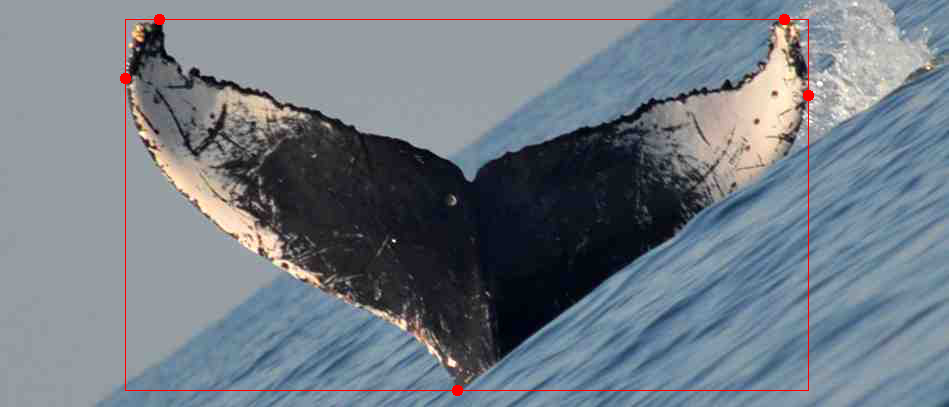

In [3]:
from PIL import Image as pil_image
from PIL.ImageDraw import Draw
from os.path import isfile

def expand_path(p):
    if isfile('../bounding/train/' + p): return '../bounding/train/' + p
    if isfile('../bounding/test/' + p): return '../bounding/test/' + p
    return p

def read_raw_image(p):
    return pil_image.open(expand_path(p))

def draw_dot(draw, x, y):
    draw.ellipse(((x-5,y-5),(x+5,y+5)), fill='red', outline='red')

def draw_dots(draw, coordinates):
    for x,y in coordinates: draw_dot(draw, x, y)

def bounding_rectangle(list):
    x0, y0 = list[0]
    x1, y1 = x0, y0
    for x,y in list[1:]:
        x0 = min(x0, x)
        y0 = min(y0, y)
        x1 = max(x1, x)
        y1 = max(y1, y)
    return x0,y0,x1,y1

filename,coordinates = data[1]
box = bounding_rectangle(coordinates)
img = read_raw_image(filename)
draw = Draw(img)
draw_dots(draw, coordinates)
draw.rectangle(box, outline='red')
img

In [4]:
# Define useful constants
img_shape  = (128,128,1)
anisotropy = 2.15

In [5]:
import random
import numpy as np
from scipy.ndimage import affine_transform
from keras.preprocessing.image import img_to_array

# Read an image as black&white numpy array
def read_array(p):
    img = read_raw_image(p).convert('L')
    return img_to_array(img)

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

# Compute the coordinate transformation required to center the pictures, padding as required.
def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))

# Apply an affine transformation to an image represented as a numpy array.
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)

# Read an image for validation, i.e. without data augmentation.
def read_for_validation(p):
    x  = read_array(p)
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t 

# Read an image for training, i.e. including a random affine transformation
def read_for_training(p):
    x  = read_array(p)
    t  = build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.9, 1.0),
            random.uniform(0.9, 1.0),
            random.uniform(-0.05*img_shape[0], 0.05*img_shape[0]),
            random.uniform(-0.05*img_shape[1], 0.05*img_shape[1]))
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t   

# Transform corrdinates according to the provided affine transformation
def coord_transform(list, trans):
    result = []
    for x,y in list:
        y,x,_ = trans.dot([y,x,1]).astype(np.int)
        result.append((x,y))
    return result

In [6]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, test_size=200, random_state=1)
train += train
train += train
train += train
train += train
len(train),len(val)

(16000, 200)

In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from keras import backend as K
from keras.preprocessing.image import array_to_img
from numpy.linalg import inv as mat_inv

def show_whale(imgs, per_row=5):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

val_a = np.zeros((len(val),)+img_shape,dtype=K.floatx()) # Preprocess validation images 
val_b = np.zeros((len(val),4),dtype=K.floatx()) # Preprocess bounding boxes
for i,(p,coords) in enumerate(tqdm_notebook(val)):
    img,trans      = read_for_validation(p)
    coords         = coord_transform(coords, mat_inv(trans))
    x0,y0,x1,y1    = bounding_rectangle(coords)
    val_a[i,:,:,:] = img
    val_b[i,0]     = x0
    val_b[i,1]     = y0
    val_b[i,2]     = x1
    val_b[i,3]     = y1

idx  = 1
img  = array_to_img(val_a[idx])
img  = img.convert('RGB')
draw = Draw(img)
draw.rectangle(val_b[idx], outline='red')
show_whale([read_raw_image(val[idx][0]), img], per_row=2)

In [12]:
from keras.utils import Sequence

class TrainingData(Sequence):
    def __init__(self, batch_size=24):
        super(TrainingData, self).__init__()
        self.batch_size = batch_size
    def __getitem__(self, index):
        start = self.batch_size*index;
        end   = min(len(train), start + self.batch_size)
        size  = end - start
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        b     = np.zeros((size,4), dtype=K.floatx())
        for i,(p,coords) in enumerate(train[start:end]):
            img,trans   = read_for_training(p)
            coords      = coord_transform(coords, mat_inv(trans))
            x0,y0,x1,y1 = bounding_rectangle(coords)
            a[i,:,:,:]  = img
            b[i,0]      = x0
            b[i,1]      = y0
            b[i,2]      = x1
            b[i,3]      = y1
        return a,b
    def __len__(self):
        return (len(train) + self.batch_size - 1)//self.batch_size

random.seed(1)
a, b = TrainingData(batch_size=12)[1]
img  = array_to_img(a[0])
img  = img.convert('RGB')
draw = Draw(img)
draw.rectangle(b[0], outline='red')
show_whale([read_raw_image(train[0][0]), img], per_row=2)

In [13]:
from keras.engine.topology import Input
from keras.layers import BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Model

def build_model(with_dropout=True):
    kwargs     = {'activation':'relu', 'padding':'same'}
    conv_drop  = 0.2
    dense_drop = 0.5
    inp        = Input(shape=img_shape)

    x = inp

    x = Conv2D(64, (9, 9), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    h = MaxPooling2D(pool_size=(1, int(x.shape[2])))(x)
    h = Flatten()(h)
    if with_dropout: h = Dropout(dense_drop)(h)
    h = Dense(16, activation='relu')(h)

    v = MaxPooling2D(pool_size=(int(x.shape[1]), 1))(x)
    v = Flatten()(v)
    if with_dropout: v = Dropout(dense_drop)(v)
    v = Dense(16, activation='relu')(v)

    x = Concatenate()([h,v])
    if with_dropout: x = Dropout(0.5)(x)
    x = Dense(4, activation='linear')(x)
    return Model(inp,x)

model = build_model(with_dropout=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 64) 5248        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_18[0][0]                  
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 128, 128, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
dropout_10

dropout_18 (Dropout)            (None, 32)           0           concatenate_2[0][0]              
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 4)            132         dropout_18[0][0]                 
Total params: 503,588
Trainable params: 502,820
Non-trainable params: 768
__________________________________________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

for num in range(1, 4):
    model_name = 'cropping-%01d.h5' % num
    print(model_name)
    model.compile(Adam(lr=0.032), loss='mean_squared_error')
    model.fit_generator(
        TrainingData(batch_size=18), epochs=25, max_queue_size=12, workers=4, verbose=1,
        validation_data=(val_a, val_b),
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=9, min_delta=0.1, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.1, factor=0.25, min_lr=0.002, verbose=1),
            ModelCheckpoint(model_name, save_best_only=True, save_weights_only=True),
        ])
    model.load_weights(model_name)
    model.evaluate(val_a, val_b, verbose=0)

cropping-1.h5
Epoch 1/25
148/889 [===>..........................] - ETA: 57:55 - loss: 971.86 - ETA: 32:16 - loss: 932.49 - ETA: 24:03 - loss: 877.53 - ETA: 19:42 - loss: 735.94 - ETA: 17:06 - loss: 718.86 - ETA: 15:28 - loss: 740.97 - ETA: 14:14 - loss: 698.05 - ETA: 13:21 - loss: 728.56 - ETA: 12:40 - loss: 706.76 - ETA: 12:06 - loss: 718.71 - ETA: 11:42 - loss: 734.16 - ETA: 11:19 - loss: 714.13 - ETA: 11:00 - loss: 709.14 - ETA: 10:48 - loss: 680.70 - ETA: 10:34 - loss: 688.52 - ETA: 10:21 - loss: 677.91 - ETA: 10:20 - loss: 669.85 - ETA: 10:25 - loss: 657.45 - ETA: 10:30 - loss: 671.50 - ETA: 10:36 - loss: 670.81 - ETA: 10:40 - loss: 682.07 - ETA: 10:42 - loss: 670.94 - ETA: 10:45 - loss: 658.93 - ETA: 10:47 - loss: 657.38 - ETA: 10:51 - loss: 648.32 - ETA: 10:53 - loss: 646.51 - ETA: 10:54 - loss: 638.30 - ETA: 10:56 - loss: 636.81 - ETA: 10:57 - loss: 630.45 - ETA: 11:00 - loss: 624.21 - ETA: 11:01 - loss: 623.65 - ETA: 11:02 - loss: 622.60 - ETA: 11:04 - loss: 620.26 - ETA: 11: